In [3]:
# ! pip install pyamg
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import struct
from Inpaint_GUI import functions as datahelper
from matplotlib import pyplot as plt
from skimage.io import imread
from scipy.signal import convolve2d
from scipy.misc import toimage
import pyamg
from Inpaint_GUI import postinpaint
%matplotlib inline 

# Inpainting Images with DCGAN

The code below is best run in Google Colab on GPU. This is a tutorial style notebook which replicates the paper ["Semantic Image Inpainting with Deep Generative Models" ](https://arxiv.org/pdf/1607.07539.pdf)by Yeh R. A. *et al*.  We use the same pretrained DCGAN as the authors, and backpropagate the loss to the input z vector in order to get the closest image in the latent manifold. 

We start with defining some hyperparameters, and a function (from the github of authors) to load the model for the pretrained DCGAN. 

In [4]:
tf.reset_default_graph()

# define hyperparameters and some variables 
# the pretrained dcgan requires inputs of [64,64,64,3] [batch_size, width, height, channels]

diff_img_batch = 5 # num images to complete 
BATCH_SIZE=64 # feed in batch of 64 of same image to backprop to z  
z_dim = 100 # dimension of random noise vector, fed into generator 

lmda = 0.01 # λ ratio for prior loss, 0.003 in paper

# backprop to z function params 
iters = 100 # 1000 in paper
momentum = 0.9 
r = 0.01 # learning rate

IMAGE_SIZE = 64
CHANNELS = 3

In [5]:
def loadpb(filename, model_name='dcgan'):
    """Loads pretrained graph from ProtoBuf file
    Arguments:
        filename - path to ProtoBuf graph definition
        model_name - prefix to assign to loaded graph node names
    Returns:
        graph, graph_def - as per Tensorflow definitions
    """
    with tf.gfile.GFile(filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def,
                            input_map=None,
                            return_elements=None,
                            producer_op_list=None,
                            name=model_name)

    return graph, graph_def

# Load the DCGAN model
We load the .pb file and get the tensors that we need to inpaint later. Then we visualize the generated images to see how well the pretrained model is working. 

In [6]:
# load frozen graph
graph, graph_def = loadpb("Inpaint_GUI/dcgan-100.pb")

g_in = graph.get_tensor_by_name('dcgan/z:0')
g_out = graph.get_tensor_by_name('dcgan/Tanh:0')
g_loss = graph.get_tensor_by_name('dcgan/Mean_2:0')
d_in = graph.get_tensor_by_name('dcgan/real_images:0')
d_out = graph.get_tensor_by_name('dcgan/Sigmoid:0')



In [0]:
# optional -- add graph to tensorboard to look at the pretrained model
write = tf.summary.FileWriter('./summaries')

with tf.Session(graph=graph) as sess:
    z = np.random.randn(BATCH_SIZE, z_dim)
    sample_out = sess.run(g_out, feed_dict={g_in: z}) # the generated outputs 
    write.add_graph(graph) # optional, take a look at the graph


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


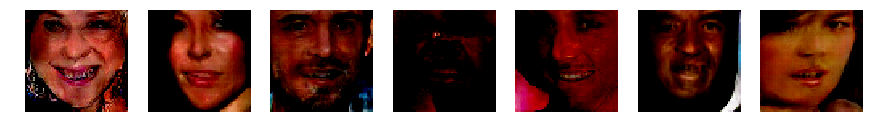

In [57]:
# check if pretrained GAN is working, visualize outputs 
fig, ax = plt.subplots(1,7,figsize=(15,15))
for i in range(7):
    img = sample_out[i,:,:,:]
    ax[i].imshow(img)
    ax[i].axis('off')

# Face Data

We downloaded the [LFW dataset](http://vis-www.cs.umass.edu/lfw/), aligned and cropped using [OpenFace](http://cmusatyalab.github.io/openface/), and converted the data to a TFRecord file. The pretrained DCGAN was trained using [CelebA dataset.](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 

In [7]:
with graph.as_default():
  dataset = tf.data.TFRecordDataset(filenames="Inpaint_GUI/data.tfrecord")
  dataset  = dataset.map(datahelper.extract_fn)

  # dataset = tf.data.TFRecordDataset.from_tensor_slices(dataset)
  dataset = dataset.shuffle(buffer_size=300)
  dataset = dataset.batch(diff_img_batch)


  iterator = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
  init_op = iterator.make_initializer(dataset)

  # batched data to feed in
  image_data = iterator.get_next()
  # convert data to [-1, 1] float32 type image array
  image_data = tf.cast((image_data/255)*2  - 1, dtype=tf.float32)
  
  # create placeholders here so it's in same graph 
  mask_placeholder = tf.placeholder(tf.float32, shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
  images_placeholder = tf.placeholder(tf.float32, shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


# Pre-inpainting Functions
We define the functions that we need for the inpainting task. First, we create the masks and see what they look like. We can choose the weighted mask option if we want to use importance weighted context loss. The ratio used for center and random option must be less than 0.5, to ensure that not too much of the image is masked.  The window size (nsize) defines the neighbours taken into account and is used for the convolution of the weighted mask generation. 

In [8]:
def preprocess(image):
    # function to preprocess if using own image
    # convert to [-1, 1] float32
    image = np.array(image)

    image = np.float32((image/255)*2  - 1)

    return image
  
  
def single_to_batch(img):
    # fit image or mask to batch size
    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS).repeat(BATCH_SIZE,0)
    return img
                                
    
def make_mask(mask_type, weighted_mask = True, rgb = True, img_size = IMAGE_SIZE, ratio = 0.25, nsize = 7):
    # mask_type can be center, random, or half
    # img_size is int, defaults to 64
    # ratio is number < 0.5, either for amount masked in center or the percentage masked randomly
    # for center mask, smaller ratio = more masked -- opposite applies for random mask 
    mask = np.ones(shape=(img_size, img_size))
    
    assert(ratio < 0.5), "ratio must be less than 0.5"
    
    if mask_type == 'center':
        start = int(img_size*ratio)
        stop = int(img_size*(1-ratio))
        mask[start:stop, start:stop] = 0
    elif mask_type == 'random':
        rand_mask = np.random.randn(img_size, img_size)
        mask[rand_mask < ratio] = 0
    elif mask_type == 'half':
        half = img_size // 2
        mask[:, half:] = 0
    else:
        assert(False), "mask_type must be center, random, or half."
    if weighted_mask:
        ker = np.ones((nsize,nsize), dtype=np.float32)
        ker = ker/np.sum(ker)
        mask = mask * convolve2d(mask, ker, mode='same', boundary='symm')
    
    if not rgb:
        return mask
    else:
        return mask.reshape(img_size, img_size, 1).repeat(3,2)
    
    
def bin_inv_mask(mask, single_channel=False):
    # binarize & invert mask for poisson blending
    mask[mask > 0] = 1
    mask = np.invert(mask.astype(int))
    if single_channel:
        mask = mask[:,:,0]

    return mask
            


## Visualize Masks 

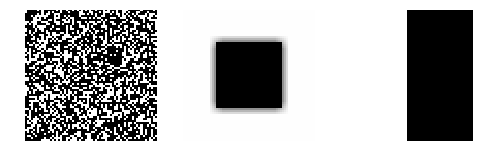

In [60]:
# make some masks to look at        
msk = [make_mask('random', weighted_mask=False), make_mask('center'), make_mask('half', weighted_mask=False)]



# visualize weighted & unweighted mask types
fig, ax = plt.subplots(1,3,figsize=(8,8))
for i in range(3):
    newimg = msk[i]
    ax[i].imshow(newimg)
    ax[i].axis('off')     
    

# Define Losses 
We use a function to get the inpainting loss, which is a combination of the context loss and prior loss (also called contextual and perceptual loss in a [previous version](https://arxiv.org/abs/1607.07539v2) of the paper). It returns either the L1 or L2 loss, and the gradient of the loss with respect to the input of the generator (z). We only work with RGB images, but the option is there for future work if we extend it to grayscale images. 

In [0]:
# losses
def get_losses(mask_placeholder, images_placeholder,l2 = False, rgb = True):
    # returns either l1 or l2 (context + perceptual) inpaint loss, and the gradient 
    if rgb:
        axis = [1,2,3]
    else:
        axis = [1,2]
            
    if not l2:
      
        context_loss = tf.abs(mask_placeholder * g_out - mask_placeholder * images_placeholder)
        context_loss = tf.reduce_sum(context_loss, axis=axis)
    else:
        context_loss = tf.reduce_sum(tf.square(mask_placeholder * g_out - mask_placeholder * images_placeholder), axis=axis)
        
        
    percept_loss = g_loss
    
    z_loss = context_loss + lmda*percept_loss
    z_gradient = tf.gradients(z_loss, g_in)
    
    
    return z_loss, z_gradient


# Backpropagate & Inpaint functions
Below is the main worker function that goes down the gradient using backpropagation with momentum to minimize the total/inpaint loss with respect to the input z. The input z is fed back to the generator in each iteration. Option to return the best images and loss of each iteration for later plotting and visualization. We experimented using different types of optimization. 

In [0]:
def get_best_z_img(masks, images, return_bests=False, loss = 1, iters=iters): 
    # run loss, grad, g_out using masks, g_in, and images
    # backpropagate to input z vec and generate images
    # return image w/ lowest loss & loss value 
    # or if return_bests, return the best images & losses of ea. iteration
    
    z = np.random.randn(BATCH_SIZE, z_dim)
    vel = 0 # initial velocity

    # get loss & gradient
    if loss==2:
      inpaint_loss, gradient = get_losses(mask_placeholder, images_placeholder, l2=True)
    else: 
      inpaint_loss, gradient = get_losses(mask_placeholder, images_placeholder)

    best_img = []
    best_loss = []

    for i in range(iters):
        # feed in batchs of masks & images, and get the inpaint loss, gradient, & output
        feed_dict = {mask_placeholder: masks, images_placeholder: images, g_in: z}
        loss, grad, gen_img = sess.run((inpaint_loss, gradient, g_out), feed_dict=feed_dict)

        grad = grad[0] # because grad.shape is (1,64,100)

        # get the bests of the batch, & append
        best_idx = np.argmin(loss)
        best_img.append(gen_img[best_idx,:,:,:])
        best_loss.append(loss[best_idx])


        v_prev = vel # prev velocity
        vel = v_prev*momentum - r*grad # prev. vel. x momentum - learningrate x gradient
        #z += vel
        z += vel*(1 + momentum) - v_prev*momentum   # dampening momentum

        z = np.clip(z, -1, 1)
            
    if return_bests:

        return best_img, best_loss
    else: 

        return gen_img[best_idx,:,:,:], loss[best_idx]
            
            
# inpaint generated image into original without blending
def inpaint(image, generated_image, mask):
  boolmsk = np.where(mask > 0)
  invboolmsk = np.where(mask==0)
  
  inpainted_image = np.zeros(image.shape)
  
  inpainted_image[boolmsk] = image[boolmsk]
  inpainted_image[invboolmsk] = generated_image[invboolmsk]
  
  
  return inpainted_image

    
    
    
 

# Inpaint & display results
We try it out using different images, but due to the time it takes to do the backpropagation, we do only a few small batches of different images. Each image is copied into it's own full batch of 64 (due to constraints of pretrained DCGAN model) and the best generated image is found using the minimum loss of the batch. 

In [0]:
with tf.Session(graph=graph) as sess:
    sess.run(init_op)
    step = 0 
    
    masks = [make_mask('random'), make_mask('center'), make_mask('half', weighted_mask=False)]
    
    batch_diff_imgs = np.array(sess.run(image_data))
    
    best_gen_imgs =[] # 5 best images in ea. batch, for 3 diff masks
    
    for i in range(len(masks)):
      msk = masks[i]
      batch_masks = single_to_batch(msk)
      
      for img in batch_diff_imgs:
        batch_img = single_to_batch(img)
        best_img, best_loss = get_best_z_img(batch_masks, batch_img)
        best_gen_imgs.append(best_img)
        step += 1


In [0]:
# make the inpainted images
inpainted_imgs = []
k = 0
for msk in masks:
  for i in range(len(batch_diff_imgs)):
    inpainted = inpaint(batch_diff_imgs[i], best_gen_imgs[k+i], msk)  
    inpainted_imgs.append(inpainted)
  k += 5

## Original Images

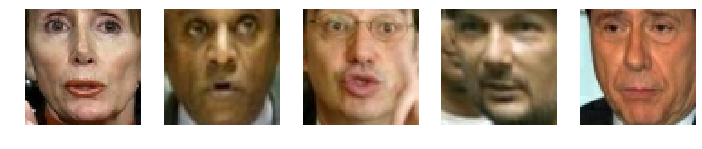

In [65]:
# Visualize original Images
fig, ax = plt.subplots(1, len(batch_diff_imgs),figsize=(12,12))
for i in range(len(batch_diff_imgs)):
    newimg = toimage(batch_diff_imgs[i])
    ax[i].imshow(newimg)
    ax[i].axis('off')   

## Inpainted Images

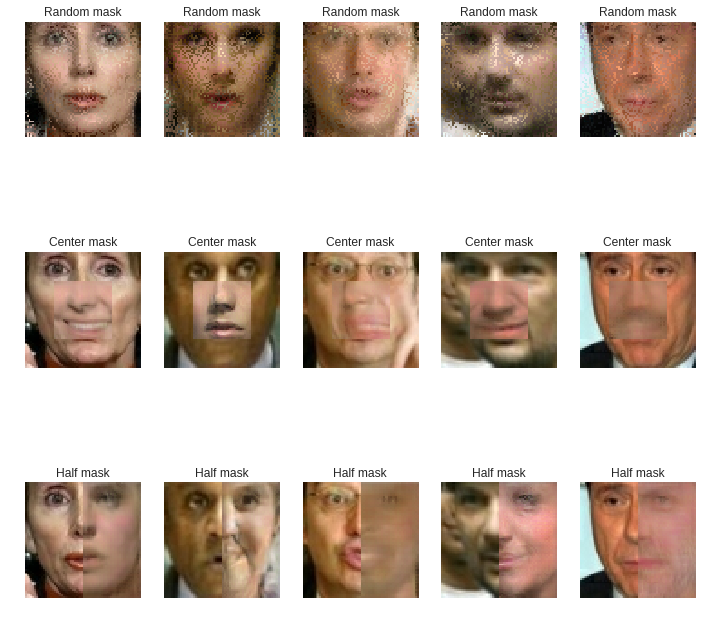

In [66]:
# display inpainted images
titles = ["Random mask", "Center mask", "Half mask"]
gfig, gax = plt.subplots(len(masks), len(batch_diff_imgs), figsize=(12,12))
  
k = 0
for i in range(len(masks)):
  for j in range(len(batch_diff_imgs)):
    img = toimage(inpainted_imgs[k + j])
    gax[i][j].imshow(img)
    gax[i][j].axis('off')  
    gax[i][j].set_title(titles[i])
  k += 5


# Postprocessing
Apply some optional post-processing with Poisson blending, then visualize the results. 

In [0]:
blended_imgs = []
k = 0
for msk in masks:
  # use helper func to binarize & invert the mask
  msk = bin_inv_mask(msk)
  msk = np.asarray(toimage(msk))
  msk.flags.writeable = True
  
  for i in range(len(batch_diff_imgs)):
    tar = batch_diff_imgs[i]
    tar = np.asarray(toimage(tar))
    tar.flags.writeable = True
    
    src = best_gen_imgs[k+i]
    src = np.asarray(toimage(src))
    src.flags.writeable = True
    
    blended = postinpaint.blend(tar, src, msk)
    blended_imgs.append(blended)
  k += 5

## Blended Images

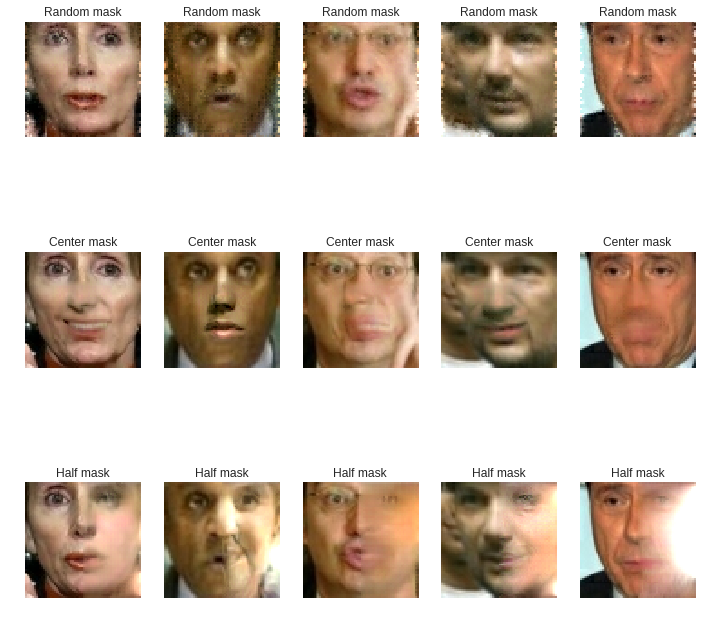

In [68]:
# display poisson edited imgs
titles = ["Random mask", "Center mask", "Half mask"]
gfig, gax = plt.subplots(len(masks), len(batch_diff_imgs), figsize=(12,12))

  
k = 0
for i in range(len(masks)):
  for j in range(len(batch_diff_imgs)):
    img = blended_imgs[k + j]
    gax[i][j].imshow(img)
    gax[i][j].axis('off')  
    gax[i][j].set_title(titles[i])
  k += 5

# Try it on your own images

Follow the instructions on the [Github repo](https://github.com/nlune/DCGAN-2019) to align & crop your picture using OpenFace.  

In [44]:
# uncomment to create folder & move images in Colab
!mkdir my_data
!mv t1.png my_data/t1.png
!mv m1.png my_data/m1.png
!mv a1.png my_data/a1.png
!mv a2.png my_data/a2.png
!mv a3.png my_data/a3.png
!mv a4.png my_data/a4.png
!mv m3.png my_data/m3.png
!ls my_data

mkdir: cannot create directory ‘my_data’: File exists
mv: cannot stat 't1.png': No such file or directory
mv: cannot stat 'm1.png': No such file or directory
mv: cannot stat 'm3.png': No such file or directory
a1.png	a2.png	a3.png	a4.png	m1.png	m3.png	t1.png


## Create mask and upload your photos 

-1.0 0.99215686


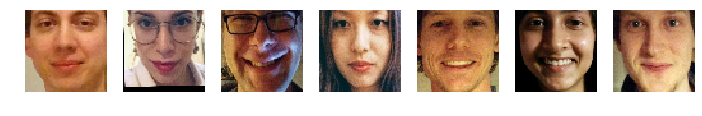

In [102]:
# 1. create your own mask
# mask_type can be center, random, or half, choose weighted_mask & ratio 
mask_type = 'center'
my_mask = make_mask(mask_type, weighted_mask=True)
mask_batch = single_to_batch(my_mask) 


# 2. store your 64x64 face image in folder my_data
batch = []
for img in glob.glob("my_data/*.png"):
    im = imread(img)
    im = preprocess(im)
    batch.append(im)

# visualize your original images
fig, ax = plt.subplots(1, len(batch), figsize=(12,12))
for i in range(len(batch)):
  plt.subplot(1, len(batch), i+1)
  plt.imshow(toimage(batch[i]))
  plt.axis('off')
  
print(np.amin(batch), np.amax(batch))

## Display masked images

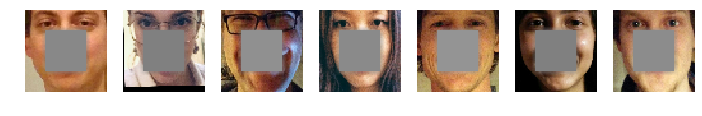

In [103]:
fig, ax = plt.subplots(1, len(batch), figsize=(12,12))
for i in range(len(batch)):
  plt.subplot(1, len(batch), i+1)
  plt.imshow(toimage(batch[i]*my_mask))
  plt.axis('off')

## Tweak parameters & run backprop

In [0]:
return_bests = False
iterations = 500
loss = 1

with tf.Session(graph=graph) as sess:
    step = 0 
    
    best_images = []
    
    for img in batch:
      img_batch = single_to_batch(img) 
      
      # 3. Choose parameters for backpropagation
      best_img, best_loss = get_best_z_img(mask_batch, 
                                           img_batch, 
                                           return_bests=return_bests, # returns list of best img from ea. iteration
                                           loss=loss, # L1 or L2 loss
                                           iters=iterations) # number of iterations for backprop to z input vec. 
    
    
      best_images.append(best_img) 



## Display postprocessed inpainted images & generated images
#### Do not run unless return_bests is set to False -- skip to next section. 

In [0]:
# poisson blend 
  msk = bin_inv_mask(my_mask)
  msk = np.asarray(toimage(msk))
  msk.flags.writeable = True
  
  blended_imgs = []
  
  for i in range(len(best_images)):
    tar = batch[i]
    tar = np.asarray(toimage(tar))
    tar.flags.writeable = True
    
    src = best_images[i]
    src = np.asarray(toimage(src))
    src.flags.writeable = True
    
    blended = postinpaint.blend(tar, src, msk)
    blended_imgs.append(blended)

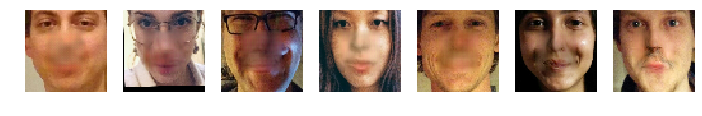

In [111]:
# display blended images
gfig, gax = plt.subplots(1, len(blended_imgs), figsize=(12,12))

for i in range(len(blended_imgs)):
  img = blended_imgs[i]
  gax[i].imshow(img)
  gax[i].axis('off')  


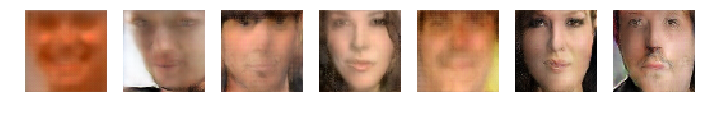

In [112]:
# display the generated images 
gfig, gax = plt.subplots(1, len(blended_imgs), figsize=(12,12))

for i in range(len(blended_imgs)):
  img = best_images[i]
  gax[i].imshow(toimage(img))
  gax[i].axis('off')  



## Traversing the manifold 
#### Only run this section if return_bests was set to True. 
We can visualize how the images change after each iteration, as we do gradient descent on the inpaint loss and change z. 

In [29]:
print(np.asarray(best_images).shape)

(3, 100, 64, 64, 3)


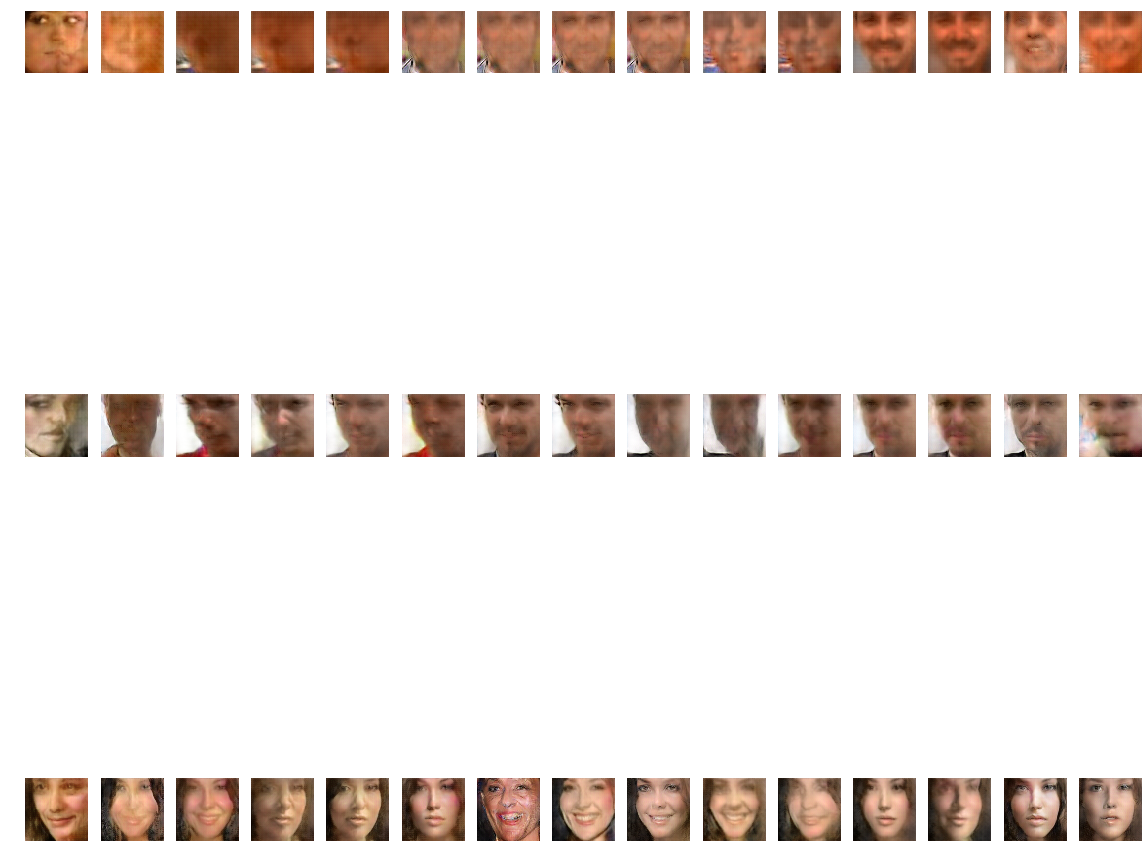

In [30]:
numshow = 15 if iterations > 15 else iterations
best_images = np.asarray(best_images)

if len(best_images) == 1:
    fig, ax = plt.subplots(len(best_images), numshow, figsize=(20,20))
    for i in range(len(best_images)):
        for j in range(numshow):
            img = toimage(best_images[i, j])
            ax[j].imshow(img)
            ax[j].axis('off')
else:
    fig, ax = plt.subplots(len(best_images), numshow, figsize=(20,20))
    for i in range(len(best_images)):
        for j in range(numshow):
            img = toimage(best_images[i, j])
            ax[i][j].imshow(img)
            ax[i][j].axis('off')
           

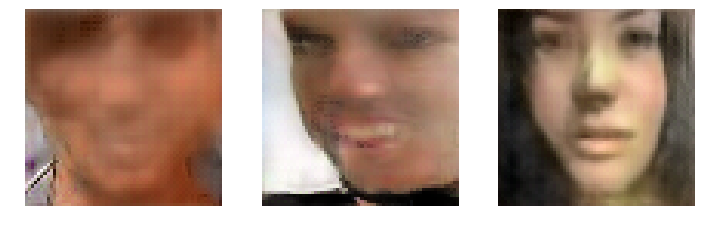

In [32]:
# show the best generated images
fig, ax = plt.subplots(1, len(best_images), figsize=(12,12))
for i in range(len(best_images)):                
    ax[i].imshow(toimage(best_images[i,iterations - 1]))
    ax[i].axis('off')